# Applying Data Science Model Development (lasso)

## 1. Preprocess the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 20.3 MB/s eta 0:00:00


In [3]:
# === Step 0: Import Libraries ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [4]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("/content/drive/MyDrive/ERP/Regression/Final_bayes_knn_ols_svm_svd2.csv.gz", compression="gzip")

df

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30
0,9.447491e+05,0.181549,NaN,-0.003279,3.541786e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,-0.025309,0.016282,-0.089450,0.043796,0.088826,-0.064235,0.002094,-0.138671,0.195853,-0.046028
1,1.765783e+04,0.181549,0.098608,0.040249,1.437969e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,-0.006860,-0.001299,0.037703,-0.004624,-0.021918,0.020632,0.002119,0.028952,-0.023026,0.031080
2,-2.502728e+04,0.181549,-0.168453,0.040249,1.246335e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,-0.024010,0.043937,-0.094405,0.137112,0.325136,-0.312155,0.060476,-0.039658,0.024693,-0.009914
3,1.023630e+03,0.181549,0.020692,0.028005,7.675140e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,-0.032123,0.058259,-0.005115,0.001183,-0.005164,0.008355,-0.002228,-0.005836,0.008682,-0.001133
4,6.034728e+02,0.181549,0.013782,0.028005,7.037159e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,-0.047808,0.348102,0.002087,-0.001183,-0.011500,0.012776,-0.003292,-0.000347,0.000665,-0.007189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,0.181549,0.188289,0.040249,-7.980458e+03,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0.036808,-0.053543,0.179606,-0.150421,-0.323482,0.279850,-0.039299,0.233081,-0.328418,-0.010133
477073,-1.343988e+04,-0.028028,-0.004174,0.040249,-1.343954e+04,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0.046839,-0.054610,0.105470,0.007683,0.008505,-0.030801,0.022448,0.186660,-0.283887,-0.013813
477074,-1.027999e+05,0.181549,0.126416,0.040249,-9.145863e+04,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,-0.003784,0.003248,0.012866,-0.145435,0.035106,-0.006755,-0.016849,-0.229176,-0.222943,0.004930
477075,-7.534849e+01,-0.024172,0.000283,0.000499,-9.680114e+05,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0.001070,-0.000428,0.022696,0.047734,0.115743,0.059615,-0.118509,-0.001196,0.006926,0.005860


In [5]:
# create a df for classification
df_cls = df.copy()

# drop NaN
df_cls = df_cls.dropna()
df_cls.isna().sum().sum()

np.int64(0)

In [6]:
def create_success_flag(df):
    """
    Create a binary 'success' column based on revenue, net income, and cash flow thresholds.
    A company is considered successful if:
        - revenue_usd > 455.230 (top quartile)
        - net_income_usd > 0 (profitable)

    Parameters:
        df (pd.DataFrame): Input DataFrame containing startup financial data.

    Returns:
        df_new (pd.DataFrame): DataFrame with the added 'success' column.
        success_counts (pd.Series): Count of 0s and 1s in the 'success' column.
    """

    # Make a copy of the original DataFrame to preserve the input
    df_new = df.copy()

    # Define the success condition as a binary indicator
    # This checks whether all three conditions are met for each row
    df_new["success"] = (
        (df_new["revenue_usd"] > 455.230) &      # Top quartile of revenue
        (df_new["net_income_usd"] > 0)           # Positive net income
    ).astype(int)  # Convert boolean values to 0 or 1

    # Drop the columns used for creating the target to avoid data leakage
    df_new.drop(columns=["revenue_usd", "net_income_usd"], inplace=True)

    # Count how many startups are labeled as success (1) and not success (0)
    success_counts = df_new["success"].value_counts().sort_index()

    return df_new, success_counts

In [7]:
# create a df for classification
df_class, success_counts = create_success_flag(df_cls)
print(df_class["success"])
print(success_counts)

1         1
2         0
3         1
4         1
5         1
         ..
477072    0
477073    0
477074    0
477075    0
477076    0
Name: success, Length: 476920, dtype: int64
success
0    390252
1     86668
Name: count, dtype: int64


In [8]:
# CLASSIFICATION: Define target and feature columns
target_col_cls = "success"
feature_cols_cls = [col for col in df_class.columns if col != target_col_cls]

# Extract features and target
X_cls = df_class[feature_cols_cls].values
y_cls = df_class[target_col_cls].values

# Split into train, validation, and test sets (2D arrays only, no reshape)
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_temp_cls, y_temp_cls, test_size=0.5, random_state=42)

## 2. Define the lasso model

In [9]:
'''
# === Step 2: Define lasso Model ===
class lassoClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(lassoClassifier, self).__init__()
        self.lasso = nn.lasso(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lasso(x)             # lasso output
        out = out[:, -1, :]               # Use only last time step
        out = self.fc(out)                # Final classification layer
        return out
'''

'\n# === Step 2: Define lasso Model ===\nclass lassoClassifier(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):\n        super(lassoClassifier, self).__init__()\n        self.lasso = nn.lasso(input_size, hidden_size, num_layers,\n                            batch_first=True, dropout=dropout)\n        self.fc = nn.Linear(hidden_size, num_classes)\n\n    def forward(self, x):\n        out, _ = self.lasso(x)             # lasso output\n        out = out[:, -1, :]               # Use only last time step\n        out = self.fc(out)                # Final classification layer\n        return out\n'

## 3. Tune hyperparameters by Optuna

In [10]:
# === Step 3: Optuna Hyperparameter Tuning for Lasso Classification ===
def objective(trial):
    C = trial.suggest_float("C", 1e-4, 10.0, log=True)  # Inverse of regularization strength

    model = LogisticRegression(
        penalty="l1",
        C=C,
        solver="liblinear",  # L1-compatible solver
        max_iter=1000
    )

    # Optional: Use only a subset (e.g., 2000 samples) for tuning
    sample_idx = np.random.choice(len(X_train_cls), size=2000, replace=False)
    X_tune = X_train_cls[sample_idx]
    y_tune = y_train_cls[sample_idx]

    model.fit(X_tune, y_tune)

    f1_vs_C_list = []
    y_pred = model.predict(X_val_cls)
    f1 = f1_score(y_val_cls, y_pred)
    f1_vs_C_list.append((C, f1))

    return 1.0 - f1  # Minimize (1 - F1)

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-07-09 00:34:07,690] A new study created in memory with name: no-name-077fce82-d4c6-4cb2-9665-4bcf1873c989
[I 2025-07-09 00:34:07,858] Trial 0 finished with value: 0.8498033907045703 and parameters: {'C': 2.1273420243950967}. Best is trial 0 with value: 0.8498033907045703.
[I 2025-07-09 00:34:07,918] Trial 1 finished with value: 0.9878576307201943 and parameters: {'C': 0.06764749502393572}. Best is trial 0 with value: 0.8498033907045703.
[I 2025-07-09 00:34:07,938] Trial 2 finished with value: 1.0 and parameters: {'C': 0.0003986190050838209}. Best is trial 0 with value: 0.8498033907045703.
[I 2025-07-09 00:34:07,997] Trial 3 finished with value: 0.9598715890850722 and parameters: {'C': 0.13230524997408133}. Best is trial 0 with value: 0.8498033907045703.
[I 2025-07-09 00:34:08,077] Trial 4 finished with value: 0.9893738140417457 and parameters: {'C': 0.3452421493095613}. Best is trial 0 with value: 0.8498033907045703.
[I 2025-07-09 00:34:08,099] Trial 5 finished with value: 1.0 

Best hyperparameters: {'C': 8.969943140155053}


## 4. Re-learn with the optimized parameters

In [11]:
# === Step 4: Train Final Lasso Classification Model ===

# Use best C from Optuna (inverse of regularization strength)
C = best_params["C"]

# Initialize and train L1-regularized logistic regression model
lasso_clf = LogisticRegression(
    penalty="l1",
    C=C,
    solver="liblinear",
    max_iter=1000
)
lasso_clf.fit(X_train_cls, y_train_cls)

# Predict on validation set
y_pred_val = lasso_clf.predict(X_val_cls)

# Evaluate classification performance
val_f1 = f1_score(y_val_cls, y_pred_val)
val_acc = accuracy_score(y_val_cls, y_pred_val)

print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Validation F1 Score: 0.1238
Validation Accuracy: 0.8211


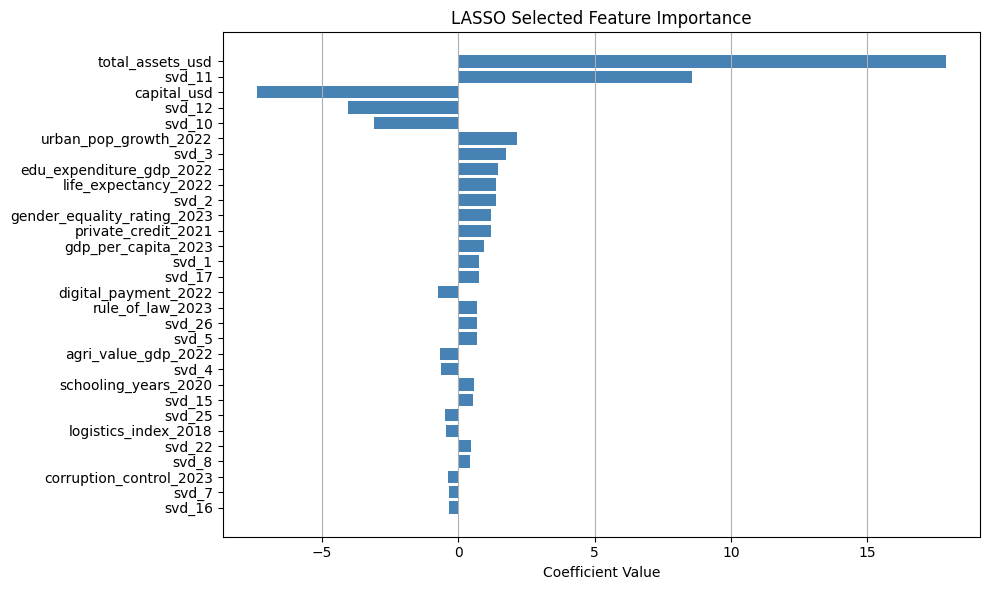

In [12]:
# === Get feature names ===
feature_names = feature_cols_cls if 'feature_cols_cls' in locals() else [f"f{i}" for i in range(X_train.shape[1])]

# === Extract coefficients from the trained Lasso model ===
coefficients = lasso_clf.coef_[0]  # For binary classification

# === Create a DataFrame with feature names and coefficients ===
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

# === Filter non-zero coefficients (selected features) ===
selected_features = coef_df[coef_df["coefficient"] != 0].copy()

# === Compute absolute value and select top 30
selected_features["abs_coef"] = selected_features["coefficient"].abs()
selected_features.sort_values("abs_coef", ascending=False, inplace=True)
top_features = selected_features.head(30)

# === Export selected features to CSV ===
top_features.to_csv("/content/drive/MyDrive/ERP/Regression/lasso_selected_top30_features_cls.csv", index=False)

# === Plot bar chart ===
plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"], top_features["coefficient"], color="steelblue")
plt.title("LASSO Selected Feature Importance")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [13]:
# === Get predicted probabilities for each class ===
probs = lasso_clf.predict_proba(X_val_cls)
prob_0 = probs[:, 0]
prob_1 = probs[:, 1]

# === Get predicted class labels ===
predicted_labels = lasso_clf.predict(X_val_cls)

# === Combine true labels, predicted labels, and class probabilities ===
results_cls_df = pd.DataFrame({
    "true_label": y_val_cls,
    "predicted_label": predicted_labels,
    "probability_0": prob_0,
    "probability_1": prob_1
})

# === Save results to CSV file ===
results_cls_df.to_csv("/content/drive/MyDrive/ERP/Regression/classification_results.csv", index=False)

# === Preview the first few rows ===
print(results_cls_df.head())

   true_label  predicted_label  probability_0  probability_1
0           0                0       0.812963       0.187037
1           0                0       0.999989       0.000011
2           0                1       0.388932       0.611068
3           0                0       0.794319       0.205681
4           0                0       0.999987       0.000013


## 5. Evaluate the model

In [14]:
# === Step 5: Evaluation Metrics ===
def evaluate_model(model, X, y, dataset_name="", threshold=0.3):
    """
    Evaluate a trained nb classifier on given dataset.
    """
    # Predict probabilities and class labels
    prob = model.predict_proba(X)[:, 1]  # Probability of class 1
    preds = (prob > threshold).astype(int)     # Apply threshold

    # Metrics
    auc = roc_auc_score(y, prob)
    f1 = f1_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    conf_matrix = confusion_matrix(y, preds)

    # G-Mean
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)
    gmean = np.sqrt(tpr * tnr)

    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Mean G-Mean: {gmean:.4f}")

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


--- Evaluation on Training Data ---
AUC-ROC:     0.7967
F1-Score:    0.3641
Precision:   0.4687
Recall:      0.2977
Confusion Matrix:
[[252647  20490]
 [ 42634  18073]]
Mean G-Mean: 0.5248


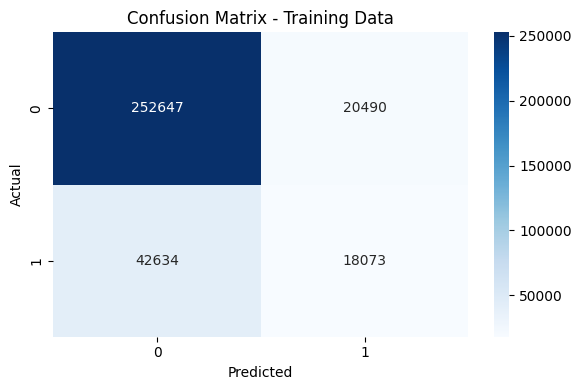


--- Evaluation on Validation Data ---
AUC-ROC:     0.7914
F1-Score:    0.3589
Precision:   0.4603
Recall:      0.2941
Confusion Matrix:
[[54041  4486]
 [ 9185  3826]]
Mean G-Mean: 0.5211


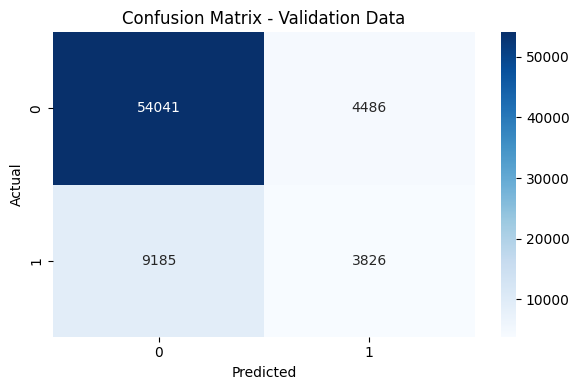


--- Evaluation on Test Data ---
AUC-ROC:     0.7990
F1-Score:    0.3674
Precision:   0.4685
Recall:      0.3022
Confusion Matrix:
[[54147  4441]
 [ 9036  3914]]
Mean G-Mean: 0.5285


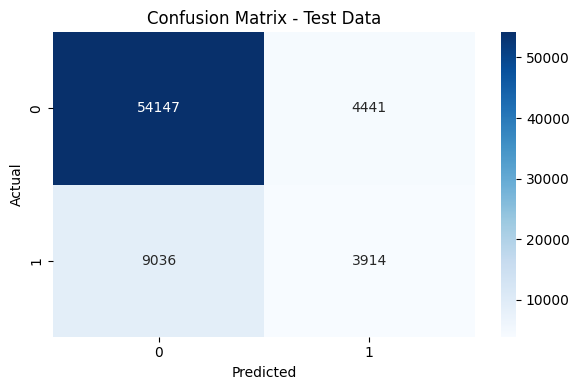

In [15]:
evaluate_model(lasso_clf, X_train_cls, y_train_cls, "Training Data")
evaluate_model(lasso_clf, X_val_cls, y_val_cls, "Validation Data")
evaluate_model(lasso_clf, X_test_cls, y_test_cls, "Test Data")


--- Evaluation on Test Data @ 0.3 ---
AUC-ROC:     0.7990
F1-Score:    0.3674
Precision:   0.4685
Recall:      0.3022
Confusion Matrix:
[[54147  4441]
 [ 9036  3914]]
Mean G-Mean: 0.5285


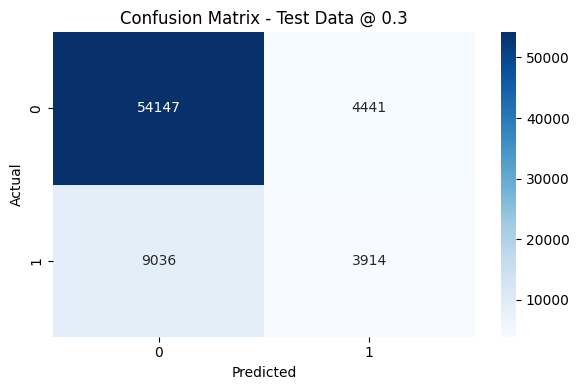


--- Evaluation on Test Data @ 0.5 ---
AUC-ROC:     0.7990
F1-Score:    0.1217
Precision:   0.5816
Recall:      0.0680
Confusion Matrix:
[[57955   633]
 [12070   880]]
Mean G-Mean: 0.2593


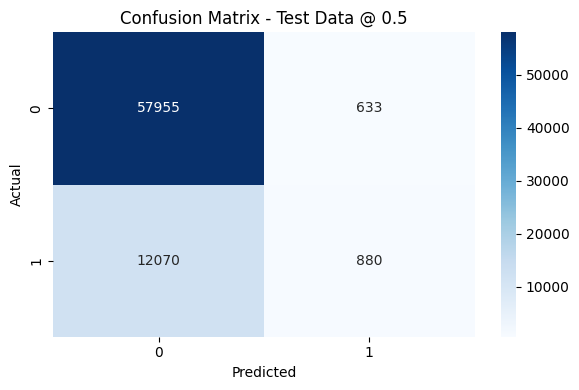


--- Evaluation on Test Data @ 0.1 ---
AUC-ROC:     0.7990
F1-Score:    0.4056
Precision:   0.2544
Recall:      0.9991
Confusion Matrix:
[[20679 37909]
 [   12 12938]]
Mean G-Mean: 0.5938


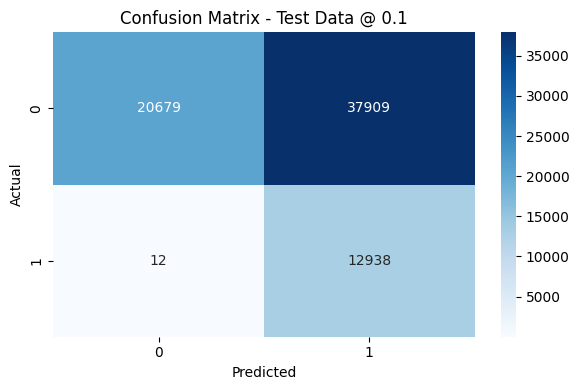

In [16]:
evaluate_model(lasso_clf, X_test_cls, y_test_cls, "Test Data @ 0.3", threshold=0.3)
evaluate_model(lasso_clf, X_test_cls, y_test_cls, "Test Data @ 0.5", threshold=0.5)
evaluate_model(lasso_clf, X_test_cls, y_test_cls, "Test Data @ 0.1", threshold=0.1)

## 6. Save the model

In [17]:
import joblib

# Save trained kNN model
joblib.dump(lasso_clf, "/content/drive/MyDrive/ERP/Regression/logit_model.pkl")

# Save best hyperparameters as CSV
params_df = pd.DataFrame([best_params])
params_df.to_csv("/content/drive/MyDrive/ERP/Regression/best_params_cls.csv", index=False)

# Save StandardScaler
#joblib.dump(scaler, "scaler.pkl")

## Optional: load the model

In [18]:
'''
import joblib

# Load best hyperparameters from CSV
loaded_params_df = pd.read_csv("best_params_cls.csv")
best_params_cls = loaded_params_df.iloc[0].to_dict()

# Convert integer-like float values to int
best_params_cls['n_neighbors'] = int(best_params_cls['n_neighbors'])
best_params_cls['p'] = int(best_params_cls['p'])
'''
'''
# Load trained xgb model
lasso_clf = joblib.load("/content/drive/MyDrive/ERP/Regression/logit_model.pkl")

# Load scaler
#scaler = joblib.load("scaler.pkl")
'''

'\n# Load trained xgb model\nlasso_clf = joblib.load("/content/drive/MyDrive/ERP/Regression/logit_model.pkl")\n\n# Load scaler\n#scaler = joblib.load("scaler.pkl")\n'